# EDA of show reviews

The goal of this analysis is to look at the data, get some insights and transform the data if needed. 

## Imports

In [1]:
# !pip install dateparser

In [2]:
import os
from pathlib import Path

import numpy as np
import pandas as pd
from tqdm import tqdm

tqdm.pandas()

In [3]:
from shows_analysis.code.preprocessing import preprocessor
from shows_analysis.code.utils.cleaning_utils import (
    cast_score_to_float,
    normalize_datetime,
    return_score,
    clean_reviews_from_scores,
)

In [4]:
SEED = 42

## Paths

In [5]:
RELATIVE_PATH = os.path.join("../../../", "data")
INPUT_PATH = os.path.join(RELATIVE_PATH, "1_anonymized_data")
OUTPUT_PATH = os.path.join(RELATIVE_PATH, "2_cleaned_reviews")


In [6]:
Path(OUTPUT_PATH).mkdir(parents=True, exist_ok=True)

## Data

### Loading data

In [7]:
movie_reviews = pd.read_parquet(
    os.path.join(INPUT_PATH, "movies_reviews.parquet")
)
movie_reviews.shape

(170894, 7)

In [8]:
series_reviews = pd.read_parquet(
    os.path.join(INPUT_PATH, "series_reviews.parquet")
)
series_reviews.shape

(35643, 7)

### Dataset overview

In [9]:
movie_reviews.sample(n=10, random_state=SEED)

,show_id,user_id,datetime,sentiment,subtitle,review_body,usefulness_ratio
165205,546,24389,24 марта 2011 01:06,good,Ломаем стереотипы,С чем у вас ассоциируется жанр 'триллер'? Личн...,5 / 8
27614,443,32941,15 января 2009 21:44,bad,Его помощь - бесценна,Уилл Смит на время вновь тасует амплуа спасите...,56 / 89
66906,395,67677,04 декабря 2010 18:48,good,'Обливэйт'.,"Вот и свершилось. Когда я сидела в кино, умира...",44 / 7
50649,598,6362,27 февраля 2011 15:07,good,Шикарное кино!,Мне очень-очень понравился фильм. И мне было д...,9 / 4
139340,1405,47809,27 августа 2021 21:27,good,Быть героем — значит сражаться и против всесил...,"Тяжелые нынче времена зверствуют, такие беспощ...",3 / 4
10585,851,19019,28 марта 2016 02:27,good,Кино не для всех...,И вновь мы наблюдаем уйму красноречивых и едки...,3 / 6
164803,1570,5815,17 декабря 2021 02:32,bad,"Не верю в то, что это следующая часть!","В преддверии попытки рецензии на данный фильм,...",1 / 1
87364,278,32158,03 января 2011 18:30,good,"Не в том месте, не в то время, или?..","Многие говорят, что хороший сюжет – это пятьде...",17 / 2
146747,883,24164,03 марта 2017 23:18,good,Из последних сил,"Есть лишь один противник, которому невозможно ...",65 / 11
166170,104,34082,19 августа 2007 22:35,good,Шедевр мультипликационного кино,Король-лев действительно велик. Он относится к...,40 / 4


In [10]:
series_reviews.sample(n=10, random_state=SEED)

,show_id,user_id,datetime,sentiment,subtitle,review_body,usefulness_ratio
17123,487,29400,07 сентября 2011 13:17,good,Мерлин? Изумительно!,Я довольно давно искала легкий и интересный се...,66 / 11
29947,357,65452,05 июля 2020 14:14,bad,Так дела не делаются,"Как мне кажется, этот сериал подойдет в основн...",31 / 166
14526,864,65059,05 августа 2015 21:39,good,"Прекрасная Ева Грин и Ко, или Сезон Номер Два","Я так долго бежала от тьмы,\nно очутилась в ещ...",12 / 0
8471,611,17331,04 января 2011 20:52,good,"Ну вот, уже что то!",Пускай это и снято на основе американского сер...,13 / 13
5288,1230,51753,20 декабря 2018 10:34,good,Молчаливое зло,Пару лет назад я читала книгу 'Правда о деле Г...,73 / 20
17419,535,63096,30 октября 2020 16:36,good,Второй сезон,Коронавирусные реалии и серьёзно развивающаяся...,3 / 2
1043,371,38653,26 августа 2009 14:50,good,Я обожаю задумку,В этом сериале отличная задумка. Не знаю как в...,36 / 0
30271,711,2093,19 апреля 2013 15:24,good,«Война меняет людей. Станешь ли ты как я или н...,Фильм сделан удивительно хорошо. На протяжении...,71 / 40
33923,1252,48173,05 июня 2021 00:53,neutral,Глубокий смысл или попкорновый треш?,"- I love you too.\n- Yeah, don’t go on about i...",5 / 2
17767,1015,49216,16 октября 2016 22:05,good,Should i stay or should i go,Я в восторге! Правда! Честно!<p>Наткнулась я к...,17 / 5


Let's merge datasets

In [11]:
movie_reviews.insert(2, "type", "movie")
series_reviews.insert(2, "type", "series")

reviews = pd.concat([movie_reviews, series_reviews]).reset_index(drop=True)

In [12]:
reviews.sample(n=10, random_state=SEED)

,show_id,user_id,type,datetime,sentiment,subtitle,review_body,usefulness_ratio
31211,579,26804,movie,16 февраля 2019 14:28,good,Обзор на фильм 'Аквамен',"Киновселенная DC, которая довольно серьезный к...",6 / 14
72046,98,65761,movie,02 ноября 2013 22:56,good,Просторы другой тональности,"Не всякая карта расскажет тебе, чем богато зве...",9 / 3
12824,217,7758,movie,19 июля 2010 15:32,good,"«Я была здесь лишь один момент, а потом меня н...",Этот фильм долго пылился на жестком диске и вч...,14 / 6
203242,742,56263,series,22 сентября 2016 18:20,good,"Между мыслью и реальностью, между движением и ...",Что могу сказать... Никогда не любила сериал п...,6 / 10
199423,643,33423,series,19 ноября 2010 15:28,good,"Пацаны смотрят вдаль и верят, но трамвай не е...",О сериале 'Реальные пацаны' узнал еще летом. К...,91 / 25
125237,844,1885,movie,06 апреля 2015 17:19,good,"Сдох твой Бобик, Джонни!","Нюквисту – «Оскар»! (Тому самому, из шведской ...",11 / 2
165963,495,8245,movie,14 января 2010 02:45,good,И колокола в финале...,Странные я испытал эмоции при просмотре этой л...,16 / 6
61509,263,58981,movie,23 февраля 2020 21:14,good,"О том, как легко служит злу. и трудно - добру",В сравнение с другими гангстерскими лентами Ск...,12 / 5
132535,63,22230,movie,27 февраля 2012 17:39,good,Всё есть число? (Амбициозная Miss Danity захот...,"А знаете, этот фильм стоит смотреть одному.<p>...",4 / 1
60474,706,48935,movie,23 февраля 2014 18:31,good,'Джанго' наоборот.,"Итак, для начала статистика. Данная картина бы...",6 / 6


### Dataset Close Look

In this section, let's look at what columns we have, what type they are, how many non-zero values, etc.

But before, let's replace empty strings with `NaN` values.

In [13]:
reviews.replace(r"^\s*$", np.nan, regex=True, inplace=True)

In [14]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 206537 entries, 0 to 206536
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   show_id           206537 non-null  int64 
 1   user_id           206537 non-null  int64 
 2   type              206537 non-null  object
 3   datetime          206537 non-null  object
 4   sentiment         206537 non-null  object
 5   subtitle          173664 non-null  object
 6   review_body       206537 non-null  object
 7   usefulness_ratio  206537 non-null  object
dtypes: int64(2), object(6)
memory usage: 12.6+ MB


As we can see, `subtitle` is empty sometimes.

### Memory optimization

Also, we should better be treating `sentiment` and `type` columns as categorical.  
One of the benefits of such transformation is the dataset will be more efficiently stored.

In [15]:
reviews[["type", "sentiment"]] = reviews[["type", "sentiment"]].astype("category")

In [16]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 206537 entries, 0 to 206536
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype   
---  ------            --------------   -----   
 0   show_id           206537 non-null  int64   
 1   user_id           206537 non-null  int64   
 2   type              206537 non-null  category
 3   datetime          206537 non-null  object  
 4   sentiment         206537 non-null  category
 5   subtitle          173664 non-null  object  
 6   review_body       206537 non-null  object  
 7   usefulness_ratio  206537 non-null  object  
dtypes: category(2), int64(2), object(4)
memory usage: 9.8+ MB


We've just saved about 2.7 MB out of 12.6 MB (around 20%), which isn't bad for a one line of code.

## Tasks

Based on this look I've determined some things to do:
* Look at the columns, determine the number of unique values, duplicates, etc.
* **[+]** Normalize `datetime` column 
* **[+]** Calculate `usefulness_ratio` based on the format `likes / dislikes`
* **[+]** Extract user scores from reviews

## EDA

### `datetime`

#### Transformation

Currently, `datetime` looks like this:

In [17]:
reviews["datetime"][0]

'09 марта 2022 21:51'

I could create map with months manually, replace month for every date and then change the format, but I will use `dateparser` package 

In [18]:
reviews["datetime_casted"] = [
    normalize_datetime(datetime) for datetime in tqdm(reviews["datetime"].values)
]
reviews["datetime_casted"] = pd.to_datetime(reviews["datetime_casted"])

100%|██████████| 206537/206537 [04:19<00:00, 794.42it/s]


Now we can extract valuable information from the `datetime` column

### `usefulness_ratio`

#### Transformation

Currently, `usefulness_ratio` looks like this:

In [19]:
reviews["usefulness_ratio"].sample(10, random_state=SEED)

31211      6 / 14
72046       9 / 3
12824      14 / 6
203242     6 / 10
199423    91 / 25
125237     11 / 2
165963     16 / 6
61509      12 / 5
132535      4 / 1
60474       6 / 6
Name: usefulness_ratio, dtype: object

We can replace `/` with `-` and then evaluate expression to get difference between likes and dislikes for the review. Let's do this.

In [20]:
reviews["usefulness_ratio_transformed"] = (
    reviews["usefulness_ratio"].replace(" / ", "-", regex=True).progress_apply(eval)
)

100%|██████████| 206537/206537 [00:00<00:00, 254579.62it/s]


#### Analysis

In [21]:
reviews["usefulness_ratio_transformed"].describe()

count    206537.000000
mean          3.836339
std          67.749343
min       -9332.000000
25%          -1.000000
50%           4.000000
75%          12.000000
max        4921.000000
Name: usefulness_ratio_transformed, dtype: float64

We have some pretty big outliers

In [22]:
reviews["usefulness_ratio_transformed"].value_counts()[:20]

 1     11019
 2     10768
 0     10227
 3     10206
 4      9391
 5      8603
-1      7683
 6      7380
 7      6798
 8      6173
-2      6030
 9      5668
 10     5085
 11     4837
-3      4608
 12     4185
-4      3936
 13     3819
 14     3424
-5      3184
Name: usefulness_ratio_transformed, dtype: int64

In [23]:
usefulness = reviews["usefulness_ratio_transformed"]

In [24]:
usefulness.quantile(0.05), usefulness.quantile(0.95)

(-29.0, 41.0)

<AxesSubplot: >

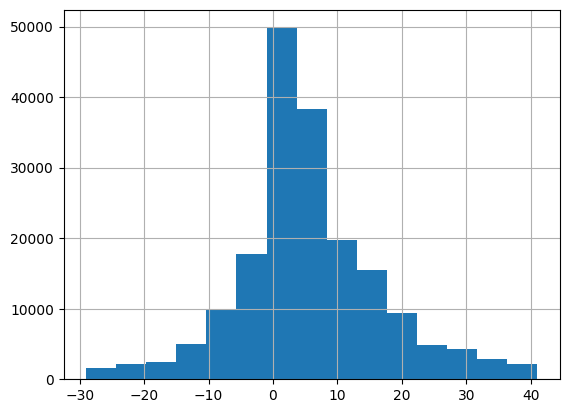

In [25]:
usefulness[
    (usefulness >= usefulness.quantile(0.05))
    & (usefulness <= usefulness.quantile(0.95))
].hist(bins=15)


We can see that reviews are usually not very useful, but there are more useful ones than useless ones.

### `review_body`

Some reviews have user's score in them. The scores located inside the review (usually, at the end).  
Firstly, we need to extract the scores (we can use them as an additional feature), then we need to remove them from the reviews, so they won't spoil the generalization ability of classifier.

Empirically, the next basic approach was developed. 

#### Transformation

##### Getting scores

In [26]:
prep = preprocessor.Preprocessor()

In [27]:
scores_and_indices = [
    return_score(prep, review) for review in tqdm(reviews["review_body"].values)
]

 10%|█         | 21300/206537 [00:00<00:08, 22704.57it/s]/home/extremesarova/projects/shows_analysis/venv/lib/python3.8/site-packages/bs4/__init__.py:431: MarkupResemblesLocatorWarning: "http://www.agvaya.ru/?p=721#more-721" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(
 87%|████████▋ | 179915/206537 [00:07<00:01, 24585.92it/s]/home/extremesarova/projects/shows_analysis/venv/lib/python3.8/site-packages/bs4/__init__.py:431: MarkupResemblesLocatorWarning: "http://www.kinopoisk.ru/user/5016861/comment/2221734/" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(
100%|██████████| 206537/206537 [00:08<00:00, 23732.13it/s]


In [28]:
scores, score_sentence_indices = list(map(list, zip(*scores_and_indices)))

In [29]:
reviews["scores"] = scores

##### Cleaning reviews from scores

In [30]:
reviews["review_body_cleaned"] = clean_reviews_from_scores(
    reviews["review_body"].values, score_sentence_indices
)

Removing scores from reviews:   0%|          | 0/206537 [00:00<?, ?it/s]

#### Analysis

In [31]:
counts = reviews["scores"].value_counts(ascending=False)

In [32]:
counts

                          77321
10 из 10                  47417
9 из 10                   20113
8 из 10                   18231
7 из 10                   12245
                          ...  
6.8/10                        1
4 мультипаспорта из 10        1
7из 10                        1
7 из 10                       1
7 из 10 Йесодов.              1
Name: scores, Length: 1038, dtype: int64

As we can see, we haven't found scores inside 77 393 reviews.

### `scores`

#### Transformation

##### Cleaning

Firstly, let's replace commas with dots

In [33]:
reviews["scores"] = reviews["scores"].str.replace(",", ".")

And then we will further clean the scores

In [34]:
reviews["scores"] = (
    reviews["scores"]
    .str.replace("!", ".")
    .str.replace("+", "")
    .str.replace("из", "/")
    .str.rstrip(".")
    .str.lstrip(".")
    .str.rstrip("…")
    .str.replace(" / ", "/")
    .str.replace(" /", "/")
    .str.replace("/ ", "/")
    .str.replace("//", "/")
)

/tmp/ipykernel_20330/1255257644.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  reviews["scores"]


##### Casting scores to real numbers

In [35]:
reviews["scores_cleaned"] = reviews["scores"].progress_apply(
    lambda score: cast_score_to_float(score)
)

100%|██████████| 206537/206537 [00:00<00:00, 561580.90it/s]


#### Analysis

<AxesSubplot: >

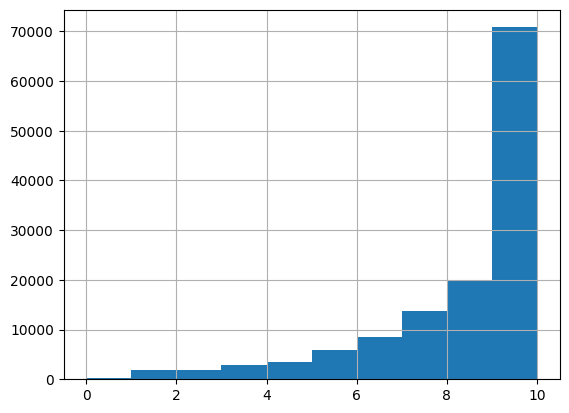

In [36]:
reviews["scores_cleaned"].hist(bins=10)

In [37]:
reviews.columns

Index(['show_id', 'user_id', 'type', 'datetime', 'sentiment', 'subtitle',
       'review_body', 'usefulness_ratio', 'datetime_casted',
       'usefulness_ratio_transformed', 'scores', 'review_body_cleaned',
       'scores_cleaned'],
      dtype='object')

Users tend to give a high score in their reviews.

### `sentiment`

#### Transformation

Let's change labels to more established ones

In [38]:
SENTIMENT_MAP = {"good": "positive", "neutral": "neutral", "bad": "negative"}

In [39]:
reviews["sentiment"] = reviews["sentiment"].map(SENTIMENT_MAP)

## Saving merged and transformed dataset

In [40]:
columns = [
    "show_id",
    "user_id",
    "type",
    "datetime_casted",
    "sentiment",
    "subtitle",
    "review_body_cleaned",
    "usefulness_ratio_transformed",
    "scores_cleaned",
]

final_reviews = reviews[columns].rename(
    columns={
        "datetime_casted": "datetime",
        "review_body_cleaned": "review",
        "scores_cleaned": "score",
        "usefulness_ratio_transformed": "review_score",
    }
)

In [41]:
final_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 206537 entries, 0 to 206536
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   show_id       206537 non-null  int64         
 1   user_id       206537 non-null  int64         
 2   type          206537 non-null  category      
 3   datetime      206537 non-null  datetime64[ns]
 4   sentiment     206537 non-null  category      
 5   subtitle      173664 non-null  object        
 6   review        206537 non-null  object        
 7   review_score  206537 non-null  int64         
 8   score         129216 non-null  float64       
dtypes: category(2), datetime64[ns](1), float64(1), int64(3), object(2)
memory usage: 11.4+ MB


In [42]:
final_reviews.to_parquet(os.path.join(OUTPUT_PATH, "reviews.parquet"))